# Stochastic volatility: Bayesian inference

This notebook describes estimating the basic univariate stochastic volatility model with Bayesian methods via Markov chain monte carlo (MCMC) methods, as in Kim et al. (1998).

The code defining the models and the functions for taking draws from the conditional posteriors is also available in a Python script [`sv.py`](https://github.com/ChadFulton/tsa-notebooks/blob/master/src/sv.py).

In [18]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=5)

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

from src import sv

A canonical univariate stochastic volatility model from Kim et al. (1998), hereafter KSC, is:

$$
\begin{align}
y_t & = \beta 
e^{h_t / 2} \varepsilon_t & \varepsilon_t \sim N(0, 1)\\
h_{t+1} & = \mu + \phi(h_t - \mu) + \sigma_\eta \eta_t \qquad & \eta_t \sim N(0, 1) \\
h_1 & \sim N(\mu, \sigma_\eta^2 / (1 - \phi^2))
\end{align}
$$

Here, $y_t$ usually represents the mean-corrected return of some asset and $h_t$ is log-volatility. Note that $\beta$ and $\mu$ are not separately identified, so KSC normalize $\beta = 1$. However, since $\beta$ is easier to interpret, they give results in terms of $\beta = \exp(\mu / 2)$. The parameter vector is usually written as $\theta = (\phi, \sigma_\eta^2, \mu)$.

By taking squares and logs of each side of the first equation, above, we get the following observation equation (here we have set $\beta = 1$):

$$y_t^* = h_t + z_t$$

where $y_t^* = \log (y_t^2 + c)$, $z_t = \log \varepsilon_t^2$, and so $E[z_t] = 1.27036$ and $\text{Var}(z_t) = 4.93$ and $c$ is an offset to prevent numerical issues when $y_t$ is close to zero, set by KSC to $0.001$. Along with the transition equation for $h_t$, above, this forms a non-Gaussian state space model.

## Illustration

For the empirical illustration in this notebook, we will follow KSC in modeling the U.K. Sterling / U.S. Dollar exchange rate between October 1, 1981 and June 28, 1985. This is the same dataset as was used in Harvey et al. (1994), although KSC multiply the mean-corrected returns by 100 (so the results will be a little different than in the notebook replicating Harvey et al. (1994)).

Tom Doan of the RATS econometrics software package has made available the replication data at https://estima.com/forum/viewtopic.php?f=8&t=1595.

In [17]:
ex = pd.read_excel('data/xrates.xls')
dta = np.log(ex).diff().iloc[1:]

endog = (dta['USXUK'] - dta['USXUK'].mean()) * 100

*** No CODEPAGE record, no encoding_override: will use 'ascii'


## Quasi-likelihood estimation

One option for estimating the parameters of this model is the "quasi-likelihood method" of Harvey et al. (1994), in which the model is approximated by replacing $\log \varepsilon_t^2$ with a Gaussian random variable of the same mean and variance. This approach will only be valid asymptotically, although Ruiz (1994) suggests that it may perform well nonetheless.

Since this model was described fully in another notebook, we do not present it again here, but use the state space model described there and stored in [`sv.py`](../files/sv.py).

In [3]:
mod_QLSV = sv.QLSV(endog)
res_QLSV = mod_QLSV.fit()

In [4]:
print(res_QLSV.summary())

                           Statespace Model Results                           
Dep. Variable:                  USXUK   No. Observations:                  945
Model:                           QLSV   Log Likelihood               -1973.517
Date:                Sat, 14 Apr 2018   AIC                           3953.034
Time:                        21:52:08   BIC                           3967.588
Sample:                             0   HQIC                          3958.581
                                - 945                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.9909      0.010     96.107      0.000       0.971       1.011
sigma2_eta     0.0059      0.006      0.981      0.327      -0.006       0.018
mu            -0.7082      0.331     -2.143      0.0

## Bayesian estimation

KSC provide an alternative method for estimating this model using Bayesian techniques; instead of approximating $\log \varepsilon_t^2$ by a single Gaussian distribution, they approximate it with a mixture of Gaussians, so that:

$$z_t | s_t = i \sim N(m_i - 1.27036, v_i^2)$$

where $s_t$ is an indicator random variable defined so that $P(s_t = i) = q_i, i = 1, \dots, K$ where $K$ is the number of mixture components. The values of $(q_i, m_i, v_i^2)$ that define the component Gaussians are given below (see KSC Table 4, p. 371).

**Note**: we provide all Python implementations of the estimation procedure in this notebook, but the functions are also collected in the associated [`sv.py`](../files/sv.py) file.

In [5]:
# q_i, m_i, v_i^2
ksc_params = np.array([[0.04395, 2.77786,   0.16735],
                       [0.24566, 1.79518,   0.34023],
                       [0.34001, 0.61942,  0.64009],
                       [0.25750, -1.08819,  1.26261],
                       [0.10556, -3.97281,  2.61369],
                       [0.00002, -8.56686,  5.17950],
                       [0.00730, -10.12999, 5.79596]])

Conditional on $\{ s_t \}_{t=1}^T$, the observation equation at each time period is well-defined with a Gaussian noise term. Thus conditional on the parameters and the mixing indicators, the stochastic volatility problem can be cast in the form of a time-varying state space model and the Kalman filter and smoother can be used to compute posterior distributions.

KSC found that a good approximation of $\log \varepsilon_t^2$ could be achieved by setting $K=7$. Omori et al. (2007) extend this to $K=10$.

In [6]:
class TVLLDT(sm.tsa.statespace.MLEModel):
    """
    Time-varying local linear deterministic trend
    """
    def __init__(self, endog, offset=0.001):
        # Convert to log squares, with offset
        endog = np.log(endog**2 + offset)

        # Initialize base model
        super(TVLLDT, self).__init__(endog, k_states=1, k_posdef=1,
                                     initialization='stationary')

        # Setup time-varying arrays for observation equation
        self['obs_intercept'] = np.zeros((1, self.nobs))
        self['obs_cov'] = np.zeros((1, 1, self.nobs))

        # Setup fixed components of state space matrices
        self['design', 0, 0] = 1
        self['selection', 0, 0] = 1

    def update_mixing(self, indicators):
        # z_t | s_t ~ N(m_i - 1.27036, v_i^2)
        # See equation (10), p. 371
        self['obs_intercept', 0] = ksc_params[indicators, 1] - 1.27036
        self['obs_cov', 0, 0] = ksc_params[indicators, 2]

    def update(self, params, **kwargs):
        params = super(TVLLDT, self).update(params, **kwargs)

        self['state_intercept', 0, 0] = params[0] * (1 - params[1])
        self['transition', 0, 0] = params[1]
        self['state_cov', 0, 0] = params[2]

### Priors

To compute the model, we need to specify a prior distribution for the parameters in $\theta$. The prior specifications below are taken from KSC.

#### Prior for $\sigma_\eta^2$

We consider the conjugate prior:

$$\sigma_\eta^2 | \phi, \mu \sim IG(\sigma_r / s, S_\sigma / 2)$$

where we follow them setting $\sigma_r = 5$ and $S_\sigma = 0.01 \times \sigma_r = 0.05$.

#### Prior for $\phi$

Defining $\phi^* = (\phi + 1) / 2$, we specify a prior on $\phi^*$:

$$\phi^* \sim Beta(\phi^{(1)}, \phi^{(2)})$$

As discussed in KSC, this prior has support over $(-1, 1)$, enforcing stationarity of the stochastic volatility process.

Setting $\phi^{(1)} = 20$ and $\phi^{(2)} = 1.5$ implies that $E[\phi] = 0.86$.

Finally:

$$\pi(\phi) \propto \left [ \frac{(1 + \phi)}{2} \right ]^{\phi^{(1)} - 1} \left [ \frac{(1 - \phi)}{2} \right ]^{\phi^{(2)} - 1} $$

#### Prior for $\mu$

KSC suggest a diffuse prior on $\mu$ (or alternatively a slightly informative prior like $\mu \sim N(0, 10)$).

### Sampling from the conditional posteriors

KSC show that with the priors specified above, we can sample from the conditional posteriors as follows:

#### Sampling $\sigma_\eta^2$

The conditional posterior distribution is:

$$\sigma_\eta^2 | y, h, \phi, \mu \sim IG \left ( \frac{n + \sigma_r}{2},
\frac{S_\sigma + (h_1 - \mu)^2(1 - \phi^2) + \sum_{i=1}^{n-1} [(h_{t+1} - \mu) - \phi(h_t-\mu)]^2}{2} \right )$$

In [7]:
def draw_posterior_sigma2(model, states, phi, mu, prior_params=(5, 0.05)):
    sigma_r, S_sigma = prior_params

    v1 = sigma_r + model.nobs
    tmp1 = (states[0, 0] - mu)**2 * (1 - phi**2)
    tmp = np.sum(((states[0, 1:] - mu) - phi * (states[0, :-1] - mu))**2)
    delta1 = S_sigma + tmp1 + tmp

    return invgamma.rvs(v1, scale=delta1)

#### Sampling $\phi$

We can apply a Metropolis step: generating a proposal value $\phi^*$ from $N(\hat \phi, V_\theta)$ and accepting the proposal with probability

$$\exp(g(\phi^*) - g(\phi^{(i-1)}))$$

where:

$$g(\phi) = \log \pi(\phi) - \frac{(h_1 - \mu)^2 (1 - \phi^2)}{2 \sigma_\eta^2} + \frac{1}{2} \log (1 - \phi^2)$$

In [8]:
def g(phi, states, mu, sigma2, prior_params=(20, 1.5)):
    phi_1, phi_2 = prior_params

    # Prior distribution gives zero weight to non-stationary processes
    if np.abs(phi) >= 1:
        return -np.inf

    prior = ((1 + phi) / 2)**(phi_1 - 1) * ((1 - phi) / 2)**(phi_2 - 1)

    tmp1 = (states[0, 0] - mu)**2 * (1 - phi**2) / 2 * sigma2
    tmp2 = 0.5 * np.log(1 - phi**2)

    return np.log(prior) - tmp1 + tmp2

def draw_posterior_phi(model, states, phi, mu, sigma2, prior_params=(20, 1.5)):
    tmp1 = np.sum((states[0, 1:] - mu) * (states[0, :-1] - mu))
    tmp2 = np.sum((states[0, :-1] - mu)**2)
    phi_hat = tmp1 / tmp2
    V_phi = sigma2 / tmp2

    proposal = norm.rvs(phi_hat, scale=V_phi**0.5)
    g_proposal = g(proposal, states, mu, sigma2, prior_params)
    g_previous = g(phi, states, mu, sigma2, prior_params)
    acceptance_probability = np.exp(g_proposal - g_previous)

    return proposal if acceptance_probability > np.random.uniform() else phi

#### Sampling $\mu$

The conditional posterior distribution is:

$$\mu | y, h, \phi, \sigma_\eta^2 \sim N (\hat \mu, \sigma_\mu^2)$$

where:

$$
\begin{aligned}
\hat \mu & = \sigma_\mu^2 \left [ \frac{(1 - \phi^2)}{\sigma_\eta^2} h_1 + \frac{(1 - \phi)}{\sigma_\eta^2} \sum_{t=1}^{n-1} (h_{t+1} - \phi h_t) \right ] \\
\sigma_\mu^2 & = \sigma_\eta^2 \left [ (n - 1)(1 - \phi)^2 + (1 - \phi^2) \right ]^{-1}
\end{aligned}
$$

In [9]:
def draw_posterior_mu(model, states, phi, sigma2):
    sigma2_mu = sigma2 / ((model.nobs - 1) * (1 - phi)**2 + (1 - phi**2))

    tmp1 = ((1 - phi**2) / sigma2) * states[0, 0]
    tmp = ((1 - phi) / sigma2) * np.sum(states[0, 1:] - phi * states[0, :-1])
    mu_hat = sigma2_mu * (tmp1 + tmp)

    return norm.rvs(loc=mu_hat, scale=sigma2_mu**0.5)

#### Sampling $\{h_t\}_{t=1}^T$

Conditional on the mixing indicators (which yield the time-varying observation equation matrices) and the parameters, the states can be sampled via the usual simulation smoother.

#### Sampling $\{s_t\}_{t=1}^T$

Each indicator $s_t$ can only take a discrete number of values (since it is an indicator variable denoting which of the mixing distributions is active at time $t$). KSC show that the mixing indicators can be independently sampled from the following probability mass function:

$$
P[s_t = i | \cdot] \propto q_i f_N( y_t^* | h_t + m_i - 1.2704, v_i^2)
$$

where $f_N( y_t^* \mid a, b)$ denotes the probability density at $y_t^*$ of a Gaussian random variable with mean $a$ and variance $b$.

In [10]:
def mixing_posterior(mod, states):
    resid = mod.endog[:, 0] - states[0]

    # Construct the means (nobs x 7), variances (7,), prior probabilities (7,)
    means = ksc_params[None, :, 1] - 1.27036
    variances = ksc_params[:, 2]
    prior_probabilities = ksc_params[:, 0]

    # Make dimensions compatible for broadcasting
    resid = np.repeat(resid[:, None], len(variances), axis=-1)
    variances = np.repeat(variances[None, :], mod.nobs, axis=0)
    prior_probabilities = np.repeat(prior_probabilities[None, :], mod.nobs,
                                    axis=0)

    # Compute loglikelihood (nobs x 7)
    loglikelihoods = -0.5 * ((resid - means)**2 / variances +
                             np.log(2 * np.pi * variances))

    # Get (values proportional to) the (log of the) posterior (nobs x 7)
    posterior_kernel = loglikelihoods + np.log(prior_probabilities)

    # Normalize to get the actual posterior probabilities
    tmp = logsumexp(posterior_kernel, axis=1)
    posterior_probabilities = np.exp(posterior_kernel - tmp[:, None])

    return posterior_probabilities

def draw_mixing(mod, states):
    posterior_probabilities = mixing_posterior(mod, states)

    # Draw from the posterior
    variates = np.random.uniform(size=mod.nobs)
    tmp = np.cumsum(posterior_probabilities, axis=1) > variates[:, None]
    sample = np.argmax(tmp, axis=1)

    return sample

### MCMC

Below we perform 10,000 iterations to sample from the posterior. When presenting results, below, we will drop the first 5,000 iterations as the burn-in period, and of the remaining 5,000 iterations we will save only every tenth iteration. Results will then be computed from the remaining 500 iterations.

In [11]:
np.random.seed(1234)

# Setup the model and simulation smoother
mod = TVLLDT(endog)
mod.set_smoother_output(0, smoother_state=True)
sim = mod.simulation_smoother()

# Simulation parameters
n_iterations = 10000
burn = 5000
thin = 10

# Storage for traces
trace_smoothed = np.zeros((n_iterations + 1, mod.nobs))
trace_states = np.zeros((n_iterations + 1, mod.nobs))
trace_mixing = np.zeros((n_iterations + 1, mod.nobs), int)
trace_mu = np.zeros((n_iterations + 1, 1))
trace_phi = np.zeros((n_iterations + 1, 1))
trace_sigma2 = np.zeros((n_iterations + 1, 1))

# Initial values (p. 367)
trace_mixing[0] = 0
trace_mu[0] = 0
trace_phi[0] = 0.95
trace_sigma2[0] = 0.5

# Iterations
for s in range(1, n_iterations + 1):
    # Update the parameters of the model
    mod.update_mixing(trace_mixing[s-1])
    params = np.r_[trace_mu[s-1], trace_phi[s-1], trace_sigma2[s-1]]
    mod.update(params, transformed=True)
    
    # Simulation smoothing
    sim.simulate()
    states = sim.simulated_state
    trace_states[s] = states[0]

    # Draw mixing indicators
    trace_mixing[s] = draw_mixing(mod, states)
    
    # Draw parameters
    trace_phi[s] = draw_posterior_phi(mod, states, trace_phi[s-1], trace_mu[s-1], trace_sigma2[s-1])
    trace_sigma2[s] = draw_posterior_sigma2(mod, states, trace_phi[s-1], trace_mu[s-1])
    trace_mu[s] = draw_posterior_mu(mod, states, trace_phi[s-1], trace_sigma2[s-1])


### Results

Below we present the posterior means for the parameters. This replicates Table 5 from KSC. We also show the corresponding QMLE estimates. These latter are similar to the posterior means for $\phi$ and $\beta$ but the QMLE estimate of $\sigma_\eta$ is about half that from the Bayesian approach, potentially demonstrating a downside of the quasi-likelihood approach.

In [16]:
# Means of parameters
mean_phi = np.mean(trace_phi[burn::thin])
mean_sigma = np.mean(trace_sigma2[burn::thin]**0.5)
mean_beta = np.mean(np.exp(trace_mu[burn::thin] / 2))

print('Replication of Table 5 from KSC: means of posterior draws from MCMC (value from KSC in parentheses)')
print('  phi | y        = %.5f (0.97779)' % mean_phi)
print('  sigma | y      = %.5f (0.15850)' % mean_sigma)
print('  beta | y       = %.5f (0.64733)' % mean_beta)
print('')
print('QMLE estimates')
print('  phi            = %.5f' % res_QLSV.params[0])
print('  sigma          = %.5f' % res_QLSV.params[1]**0.5)
print('  beta           = %.5f' % np.exp(res_QLSV.params[2] / 2))

Replication of Table 5 from KSC: means of posterior draws from MCMC (value from KSC in parentheses)
  phi | y        = 0.97600 (0.97779)
  sigma | y      = 0.15947 (0.15850)
  beta | y       = 0.65292 (0.64733)

QMLE estimates
  phi            = 0.99091
  sigma          = 0.07663
  beta           = 0.70181


Since the parameter $\sigma_\eta$ controls the variance of the underlying stochastic volatility process, underestimation will dampen changes in the volatility process over the sample. This is shown in the graph, below.

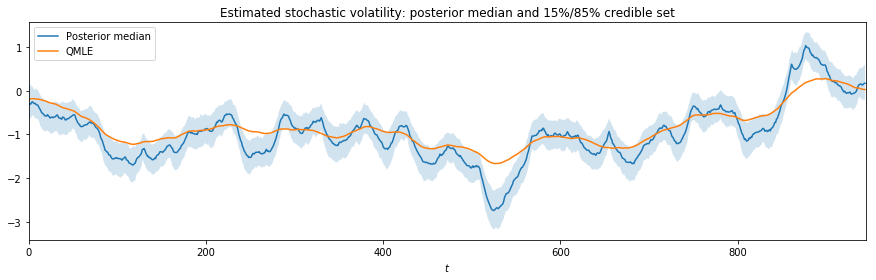

In [13]:
fig, ax = plt.subplots(figsize=(15, 4))

posterior_states = np.percentile(trace_states[burn::thin], (15, 50, 85), axis=0)

ax.plot(posterior_states[1], label='Posterior median')
ax.fill_between(np.arange(mod.nobs), posterior_states[0], posterior_states[2], alpha=0.2)
ax.plot(res_QLSV.smoothed_state[0], label='QMLE')
ax.set(title='Estimated stochastic volatility: posterior median and 15%/85% credible set',
       xlabel=r'$t$', xlim=(0, len(endog)))
ax.legend();

Finally, we may be interested in the full conditional posterior distributions of the parameters. These are shown below, along with the posterior means and the QMLE estimates.

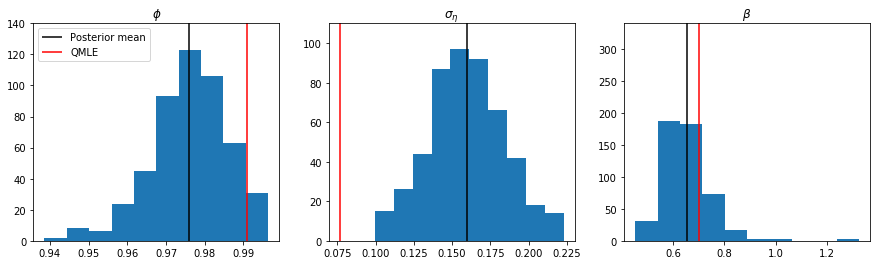

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(trace_phi[burn::thin])
ylim = (0, 140)
axes[0].vlines(mean_phi, ylim[0], ylim[1], label='Posterior mean')
axes[0].vlines(res_QLSV.params[0], ylim[0], ylim[1], color='r', label='QMLE')
axes[0].set(title=r'$\phi$', ylim=ylim)
axes[0].legend(loc='upper left')

axes[1].hist(trace_sigma2[burn::thin]**0.5)
ylim = (0, 110)
axes[1].vlines(mean_sigma, ylim[0], ylim[1], label='Posterior mean')
axes[1].vlines(res_QLSV.params[1]**0.5, ylim[0], ylim[1], color='r', label='QMLE')
axes[1].set(title=r'$\sigma_\eta$', ylim=ylim)

axes[2].hist(np.exp(trace_mu[burn::thin] / 2))
ylim = (0, 340)
axes[2].vlines(mean_beta, ylim[0], ylim[1], label='Posterior mean')
axes[2].vlines(np.exp(res_QLSV.params[2] / 2), ylim[0], ylim[1], color='r', label='QMLE')
axes[2].set(title=r'$\beta$', ylim=ylim);